In [1]:
import os
import numpy as np
import pandas as pd
# from scipy import stats
import scipy.stats as stats
from scipy.stats import mstats
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter, MultipleLocator

# Create Histograms and Bars Distribution 

Useful Link

https://saturncloud.io/blog/fitting-a-weibull-distribution-using-scipy/

https://saturncloud.io/blog/scipy-weibull-parameter-confidence-intervals-a-guide-for-data-scientists/

ISSUES IN WEIBULL FIT:

https://stats.stackexchange.com/questions/458652/scipy-stats-failing-to-fit-weibull-distribution-unless-location-parameter-is-con

https://github.com/scipy/scipy/issues/11806

In [2]:
mechanical = pd.read_csv('Mechanical_FiltAnalysis.csv')#,sep = ';')
sulfuric = pd.read_csv('Sulfuric_FiltAnalysis.csv')
nitric = pd.read_csv('Nitric_FiltAnalysis.csv')
xps = pd.read_csv('Pink_FiltAnalysis.csv')
pet = pd.read_csv('Green_FiltAnalysis.csv')


titles = ['Mechanical', 'Sulfuric', 'Nitric', 'Ex-PS', 'R-PET']

## Useful functions

### Confidence Interval computation

In [3]:
def computeCI_WeibullFit(data, confidence_level, n_bootstrap_samples):
    # Create an empty list to store bootstrap samples of the parameters
    bootstrap_samples = []
    # Perform bootstrapping to estimate confidence intervals
    # Number of bootstrap samples (increase for better accuracy)
    for _ in range(n_bootstrap_samples):
        # Generate a random bootstrap sample with replacement
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        # Fit the bootstrap sample to a Weibull distribution
        shape_boot, loc_boot, scale_boot = stats.weibull_min.fit(bootstrap_sample, floc=0)
        # Append the estimated parameters to the list
        bootstrap_samples.append((shape_boot, scale_boot))
    # Calculate quantiles for the shape and scale parameters
    shape_ci = mstats.mquantiles([sample[0] for sample in bootstrap_samples], [0.025, 0.975])
    scale_ci = mstats.mquantiles([sample[1] for sample in bootstrap_samples], [0.025, 0.975])
    return shape_ci, scale_ci

# # Confidence level
# confidence_level = 0.95
# data =mechanical
# shape_ci, scale_ci = computeCI_WeibullFit(data, 0.95, 100)
# print(f"95% Confidence Interval for Shape Parameter: ({shape_ci[0]:.4f}, {shape_ci[1]:.4f})")
# print(f"95% Confidence Interval for Scale Parameter: ({scale_ci[0]:.4f}, {scale_ci[1]:.4f})")

### Ticks labels conversion: [X] um3 --> [X / e9] mm3

In [4]:
# Define a function to format the tick labels
def custom_formatter_cub(x, pos):
    # Convert from um3 to mm3
    return f'{x / 1e9:.2f}'# mm3'

def custom_formatter_quad(x, pos):
    # Convert from um2 to mm2
    return f'{x / 1e6:.2f}'# mm2'

def custom_formatter_single(x, pos):
    # Convert from um to 1.0 mm
    return f'{x / 1e3:.2f}'# mm'

def scientific_to_decimal1(x, pos):
    return f'{x / 1e-5 : .3f}'# mm3' 

def scientific_to_decimal2(x, pos):
    return f'{x : .7f}'# mm3

## Histograms distribution for volume, surface area, and equivalent diameter

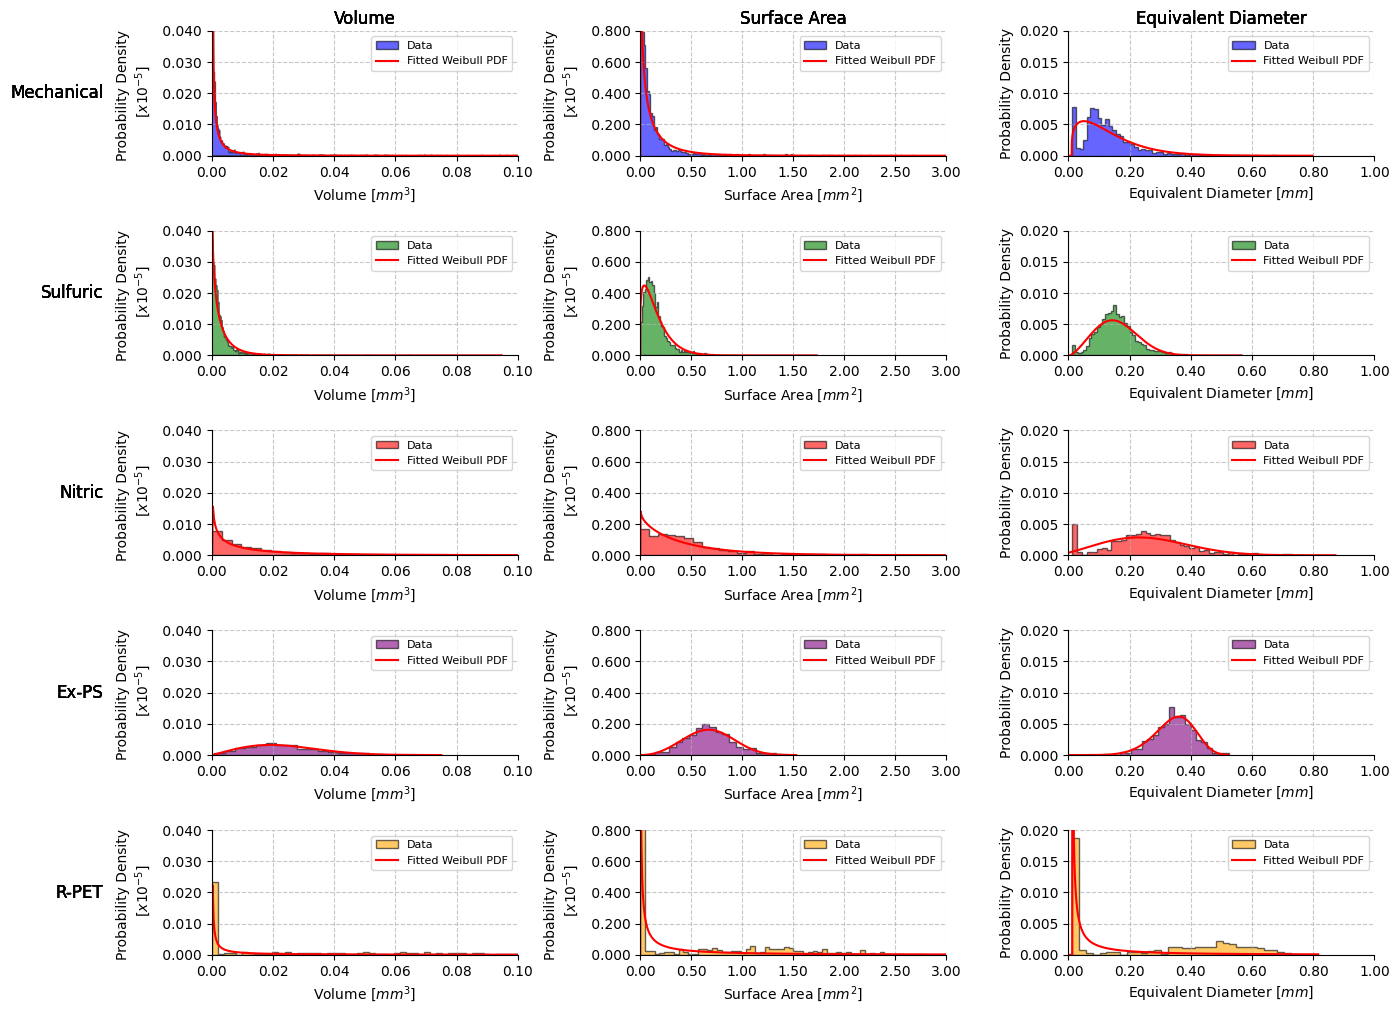

In [18]:
from scipy import stats
# 10, 15 -->
n_cols = 3
n_rows = 5

cols = ['Volume', 'Surface Area', 'Equivalent Diameter']
rows = titles
cols_um = ['$mm^3$', '$mm^2$', '$mm$']
colors = ['blue', 'green', 'red', 'purple', 'orange']
kwargs = dict(histtype='stepfilled', alpha=0.6, ec="k")

volume_params = []
volume_ci_params = []
surf_params = []
surf_ci_params = []
ed_params = []
ed_ci_params = []

fig, ax = plt.subplots(figsize = (15,12), nrows=n_rows, ncols =n_cols,  gridspec_kw={'hspace': 0.6, 'wspace': 0.4}) # tight_layout=True,sharey=True, sharex = True, sharex='col',
# fig.tight_layout()
for j in range(5):
    if j == 0:
        data = mechanical
    elif j == 1:
        data = sulfuric
    elif j == 2:
        data = nitric
    elif j == 3:
        data = xps
    elif j == 4:
        data = pet
    # Extract Volume, Surface Area and Equivalent Diameter from data
    data_vol = data['Volume3d']
    data_surf = data['VoxelFaceArea']
    data_ed = data['EqDiameter']
    # Fit the Weibull distribution to the data
    shape_vol, loc_vol, scale_vol = weibull_min.fit(data_vol, loc=0)
    shape_surf, loc_surf, scale_surf = weibull_min.fit(data_surf, loc=0)
    shape_ed, loc_ed, scale_ed = weibull_min.fit(data_ed, loc=0)
    # Weibull fit
    shape_vol_ci, scale_vol_ci = computeCI_WeibullFit(data_vol, 0.95, 100)
    shape_surf_ci, scale_surf_ci = computeCI_WeibullFit(data_surf, 0.95, 100)
    shape_ed_ci, scale_ed_ci = computeCI_WeibullFit(data_ed, 0.95, 100)
    # Plot the histogram of the original data
    if j == 2:
        # Method 1 - Square Root Rule
        num_bins = int(np.sqrt(len(data)))
        ax[j][0].hist(data_vol, density=True, bins=num_bins*4, color = colors[j], label='Data', **kwargs) # xticks = np.arange(0.0,1.0, 0.2),
        ax[j][1].hist(data_surf, density=True, bins=num_bins*2, color = colors[j], label='Data', **kwargs)
        ax[j][2].hist(data_ed, density=True, bins=num_bins*2, color = colors[j], label='Data', **kwargs)
    elif j == 4:
        # Method 1 - Square Root Rule
        num_bins = int(np.sqrt(len(data)))
        ax[j][0].hist(data_vol, density=True, bins=num_bins*8, color = colors[j], label='Data', **kwargs) # xticks = np.arange(0.0,1.0, 0.2),
        ax[j][1].hist(data_surf, density=True, bins=num_bins*4, color = colors[j], label='Data', **kwargs)
        ax[j][2].hist(data_ed, density=True, bins=num_bins*2, color = colors[j], label='Data', **kwargs)
    else:
        ax[j][0].hist(data_vol, density=True, bins='auto', color = colors[j], label='Data', **kwargs)
        ax[j][1].hist(data_surf, density=True, bins='auto', color = colors[j], label='Data', **kwargs)
        ax[j][2].hist(data_ed, density=True, bins='auto', color = colors[j], label='Data', **kwargs)
    # Generate x-values for the PDF plot
    x_vol = np.linspace(0, np.max(data_vol), 1000)
    x_surf = np.linspace(0, np.max(data_surf), 1000)
    x_ed = np.linspace(0, np.max(data_ed), 1000)
    # Plot the PDF of the fitted Weibull distribution
    ax[j][0].plot(x_vol, weibull_min.pdf(x_vol, shape_vol, loc_vol, scale_vol), 'r-', label='Fitted Weibull PDF')
    ax[j][1].plot(x_surf, weibull_min.pdf(x_surf, shape_surf, loc_surf, scale_surf), 'r-', label='Fitted Weibull PDF')
    ax[j][2].plot(x_ed, weibull_min.pdf(x_ed, shape_ed, loc_ed, scale_ed), 'r-', label='Fitted Weibull PDF')
    # SEt xlimits
    ax[j][0].set_xlim(0.0, 1e8)
    ax[j][0].set_ylim(0.0, 0.4e-6)
    # ax[j][0].xaxis.set_major_locator(MultipleLocator(base=1e7))  # Adjust the base to fit your data
    ax[j][0].xaxis.set_major_formatter(FuncFormatter(custom_formatter_cub))
    ax[j][0].yaxis.set_major_formatter(FuncFormatter(scientific_to_decimal1))
    ax[j][1].set_xlim(0.0, 3e6)
    ax[j][1].set_ylim(0.0, 8e-6)
    # ax[j][1].xaxis.set_major_locator(MultipleLocator(base=1e6))  # Adjust the base to fit your data
    ax[j][1].xaxis.set_major_formatter(FuncFormatter(custom_formatter_quad))
    ax[j][1].yaxis.set_major_formatter(FuncFormatter(scientific_to_decimal1))
    # ax[j][1].xaxis.set_major_locator(MultipleLocator(base=1e6))  # Adjust the base to fit your data
    ax[j][2].xaxis.set_major_formatter(FuncFormatter(custom_formatter_single))
    # Set limits
    ax[j][2].set_xlim(0.0, 1000)
    ax[j][2].set_ylim(0.0, 0.02)
    for i in range(n_cols):
        # Add horizontal lines
        ax[j][i].grid(linestyle='--', alpha=0.7) # axis='y',
        # Remove the upper and right spines
        ax[j][i].spines['top'].set_visible(False)
        ax[j][i].spines['right'].set_visible(False)
    # Set ylabel titles
    for axs, row in zip(ax[:,0], rows):
        axs.set_ylabel('Probability Density \n [$x10^{-5}$]', rotation=90)
    for axs, row in zip(ax[:,1], rows):
        axs.set_ylabel('Probability Density \n [$x10^{-5}$]', rotation=90)
    for axs, row in zip(ax[:,2], rows):
        axs.set_ylabel('Probability Density', rotation=90)
    # Set xlabel ticks
    for axs, par, col in zip(ax[j,:], cols, cols_um):
        axs.set_xlabel(par + ' [' + col + ']')
    pad = 5
    # Set horizontal title    
    for axs, col in zip(ax[0], cols):
        axs.annotate(col, xy=(0.5, 1), xytext=(0, pad), xycoords='axes fraction', textcoords='offset points', size='large', ha='center', va='baseline')
    # Set vertical title
    for axs, row in zip(ax[:,0], rows):
        axs.annotate(row, xy=(0, 0.5), xytext=(-axs.yaxis.labelpad - pad, 0), xycoords=axs.yaxis.label, textcoords='offset points', size='large', ha='right', va='center')
    # Append results from Weibull fits
    volume_params.append([scale_vol, shape_vol])
    volume_ci_params.append([scale_vol_ci, shape_vol_ci])
    surf_params.append([scale_surf, shape_surf])
    surf_ci_params.append([scale_surf_ci, shape_surf_ci])
    ed_params.append([scale_ed, shape_ed])
    ed_ci_params.append([scale_ed_ci, shape_ed_ci])
    for i in range(n_cols):
        ax[j][i].legend(prop={'size':8}); #['Equivalent Diameter data', 'Fitted Weibull PDF'])

fig.savefig('tannin-foams-geometries-histograms.tif')

### Bars plot - Volume, Surface Area

In [27]:
## -- Volume

# Split the elements within each array
vol_scale = [arr[0] for arr in volume_params]
vol_shape = [arr[1] for arr in volume_params]
# Split the elements within each array
first_elements = [arr[0] for arr in volume_ci_params]
second_elements = [arr[1] for arr in volume_ci_params]
# Calculate error values from confidence intervals
errors_volscale = [(up - low) / 2 for low, up in first_elements]
errors_volshape = [(up - low) / 2 for low, up in second_elements]

## -- Surface Area

# Split the elements within each array
surf_scale = [arr[0] for arr in surf_params]
surf_shape = [arr[1] for arr in surf_params]
# Split the elements within each array
first_elements = [arr[0] for arr in surf_ci_params]
second_elements = [arr[1] for arr in surf_ci_params]
# Calculate error values from confidence intervals
errors_surfscale = [(up - low) / 2 for low, up in first_elements]
errors_surfshape = [(up - low) / 2 for low, up in second_elements]

## -- Equivalent Diameter

# Split the elements within each array
ed_scale = [arr[0] for arr in ed_params]
ed_shape = [arr[1] for arr in ed_params]
# Split the elements within each array
first_elements = [arr[0] for arr in ed_ci_params]
second_elements = [arr[1] for arr in ed_ci_params]
# Calculate error values from confidence intervals
errors_edscale = [(up - low) / 2 for low, up in first_elements]
errors_edshape = [(up - low) / 2 for low, up in second_elements]

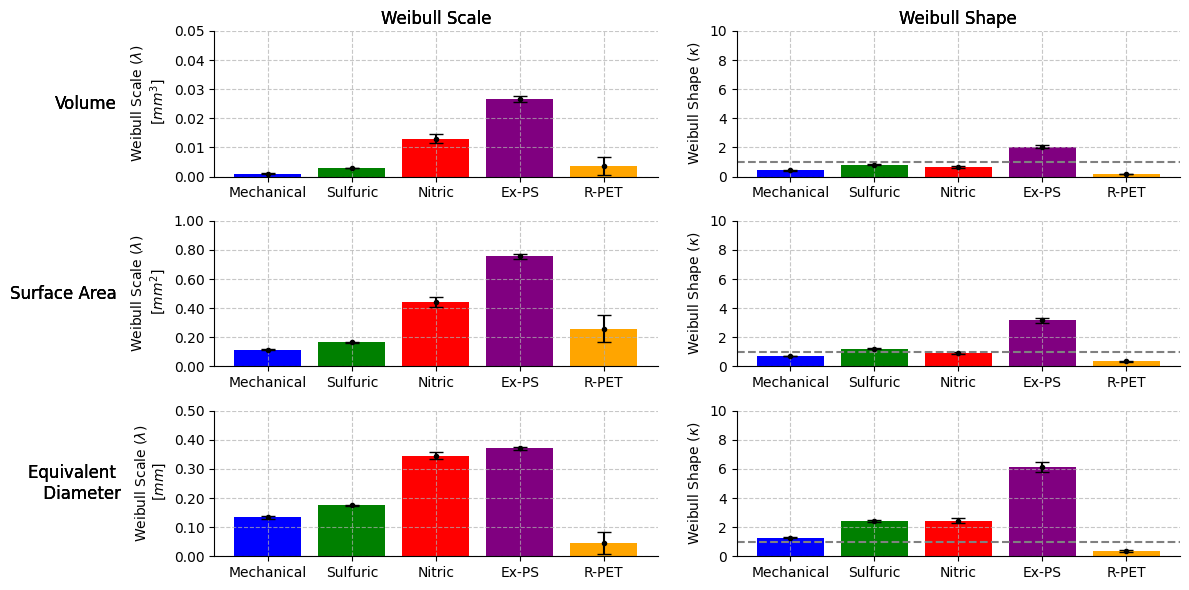

In [31]:
rows = ['Volume', 'Surface Area', 'Equivalent \n Diameter']
cols = ['Weibull Scale', 'Weibull Shape']

# Create a figure with two horizontally arranged subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 6))  # 3 rows, 2 columns
for j in range(3):
    if j == 0:
        # Subplot 1: Bar plot 1
        axs[j][0].bar(titles, vol_scale, color=colors)
        axs[j][0].errorbar(titles, vol_scale, yerr=errors_volscale, fmt='.', color='black', capsize=5, label='Confidence Interval')
        axs[j][0].yaxis.set_major_formatter(FuncFormatter(custom_formatter_cub))
        # Subplot 2: Bar plot 2
        axs[j][1].bar(titles, vol_shape, color=colors)
        axs[j][1].errorbar(titles, vol_shape, yerr=errors_volshape, fmt='.', color='black', capsize=5, label='Confidence Interval')        
    elif j == 1:
        # Subplot 1: Bar plot 1
        axs[j][0].bar(titles, surf_scale, color=colors)
        axs[j][0].errorbar(titles, surf_scale, yerr=errors_surfscale, fmt='.', color='black', capsize=5, label='Confidence Interval')
        axs[j][0].yaxis.set_major_formatter(FuncFormatter(custom_formatter_quad))
        # Subplot 2: Bar plot 2
        axs[j][1].bar(titles, surf_shape, color=colors)
        axs[j][1].errorbar(titles, surf_shape, yerr=errors_surfshape, fmt='.', color='black', capsize=5, label='Confidence Interval')
    elif j == 2:
        # Subplot 1: Bar plot 1
        axs[j][0].bar(titles, ed_scale, color=colors)
        axs[j][0].errorbar(titles, ed_scale, yerr=errors_edscale, fmt='.', color='black', capsize=5, label='Confidence Interval')
        axs[j][0].yaxis.set_major_formatter(FuncFormatter(custom_formatter_single))
        # Subplot 2: Bar plot 2
        axs[j][1].bar(titles, ed_shape, color=colors)
        axs[j][1].errorbar(titles, ed_shape, yerr=errors_edshape, fmt='.', color='black', capsize=5, label='Confidence Interval')
    axs[j][1].axhline(y = 1.0, color = 'gray', linestyle = '--') 
    # Set limits - all graph
    if j == 0:
        axs[j][0].set_ylim(0.0, 5e7)
    elif j == 1:
        axs[j][0].set_ylim(0.0, 1e6)
    elif j == 2:
        axs[j][0].set_ylim(0.0, 500)
    axs[j][1].set_ylim(0.0, 10.0)
    # Set ylabels
    for ax, row, col in zip(axs[:,0], rows, cols_um):
        ax.set_ylabel('Weibull Scale ($\lambda$)' + '\n [' + col + ']', rotation=90)
    for ax, row in zip(axs[:,1], rows):
        ax.set_ylabel('Weibull Shape ($\kappa$)', rotation=90)
    # Set horizontal titles   
    for ax, col in zip(axs[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad), xycoords='axes fraction', textcoords='offset points', size='large', ha='center', va='baseline')
    # Set vertical titles
    for ax, row in zip(axs[:,0], rows):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0), xycoords=ax.yaxis.label, textcoords='offset points', size='large', ha='right', va='center')
    for i in range(2):
        # Add horizontal lines
        axs[j][i].grid(linestyle='--', alpha=0.7) # axis='y',
        # Remove the upper and right spines
        axs[j][i].spines['top'].set_visible(False)
        axs[j][i].spines['right'].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()
# Display the plot
plt.show()

fig.savefig('tannin-foams-geometries-bars.tif')

In [22]:
print('Volume scale: ' + str(volume_params))
print('Surface area: ' + str(surf_params))
print('Equivalent diameter: ' + str(ed_params))

Volume scale: [[1007666.020129082, 0.42681617426553786], [2960574.366086348, 0.8179361421584914], [13008216.924676295, 0.669613813869609], [26724596.75698308, 2.0433296417807867], [3606868.754935134, 0.189155414061495]]
Surface area: [[116107.61394750979, 0.7045900476361828], [167000.86913220581, 1.2145453660747993], [443486.5029117733, 0.9375565816844702], [756810.4653501387, 3.153943797492351], [260079.12778017635, 0.36076288018941083]]
Equivalent diameter: [[133.2879365410976, 1.2749378458886793], [175.20875890792155, 2.432563758990397], [344.8825512472488, 2.4239364610022123], [370.94052983561323, 6.129985953382981], [45.72656477492414, 0.3432774911280722]]


## Histograms distribution for Pore Anisotropy, Elongation, Flatness 

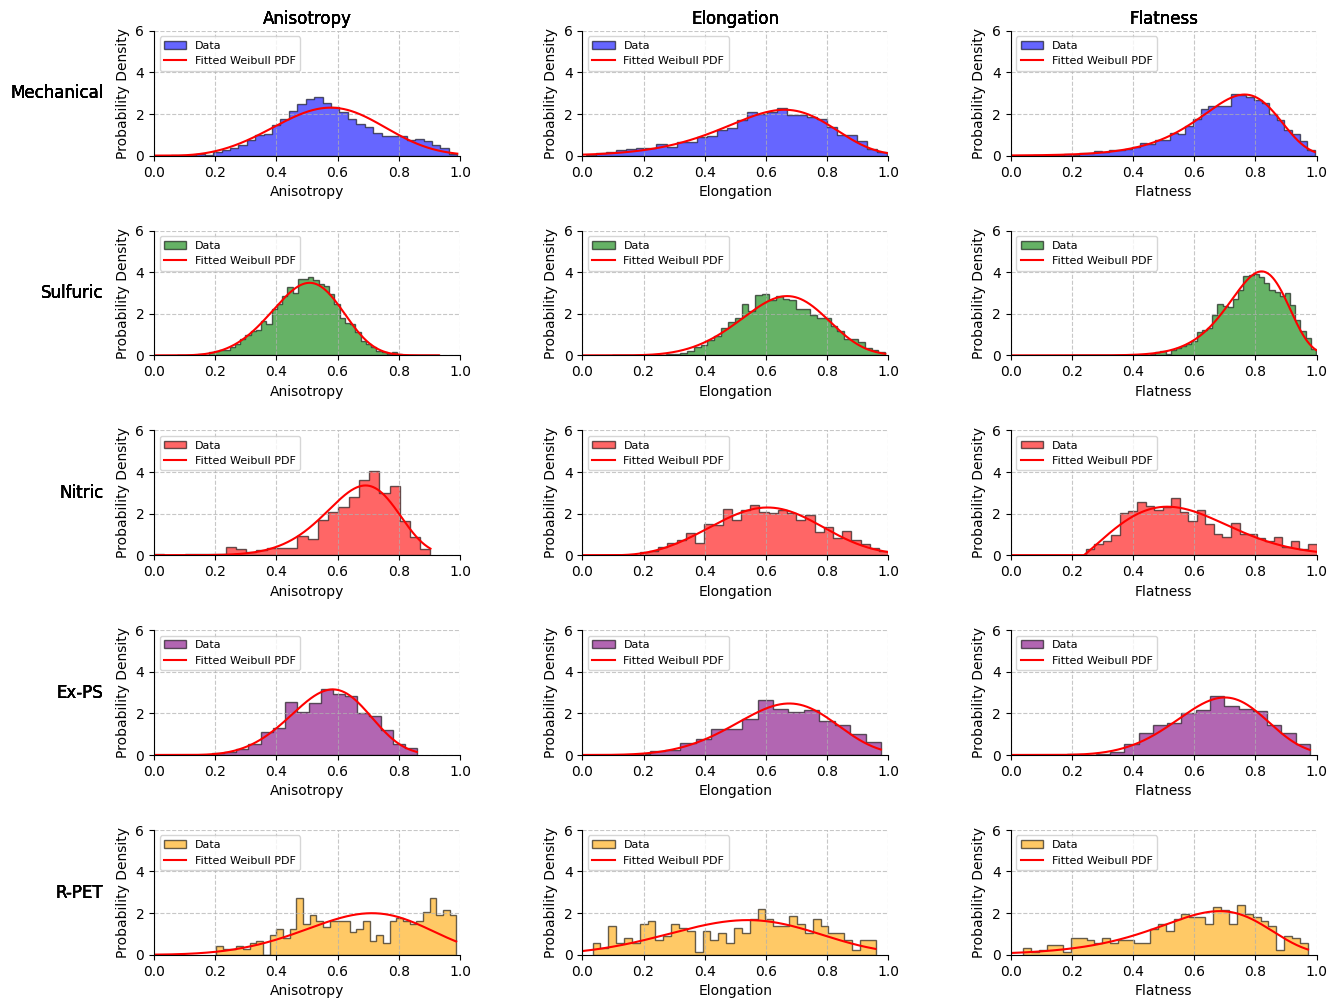

In [34]:
from scipy import stats
# 10, 15 -->
n_cols = 3
n_rows = 5

cols = ['Anisotropy', 'Elongation', 'Flatness']
rows = titles
colors = ['blue', 'green', 'red', 'purple', 'orange']
kwargs = dict(histtype='stepfilled', alpha=0.6, ec="k")

anis_params = []
anis_ci_params = []
elong_params = []
elong_ci_params = []
flatn_params = []
flatn_ci_params = []

fig, ax = plt.subplots(figsize = (15,12), nrows=n_rows, ncols =n_cols,  gridspec_kw={'hspace': 0.6, 'wspace': 0.4}) # tight_layout=True,sharey=True, sharex = True, sharex='col',
# fig.tight_layout()
for j in range(5):
    if j == 0:
        data = mechanical
    elif j == 1:
        data = sulfuric
    elif j == 2:
        data = nitric
    elif j == 3:
        data = xps
    elif j == 4:
        data = pet
    # Extract Volume, Surface Area and Equivalent Diameter from data
    data_anis = data['Anisotropy']
    data_elong = data['Elongation']
    data_flatn = data['Flatness']
    # Fit the Weibull distribution to the data
    if j == 2:
        shape_anis, loc_anis, scale_anis = weibull_min.fit(data_anis, floc = 0.00001)
    else:
        shape_anis, loc_anis, scale_anis = weibull_min.fit(data_anis, loc=0)
    shape_elong, loc_elong, scale_elong = weibull_min.fit(data_elong, loc=0)
    shape_flatn, loc_flatn, scale_flatn = weibull_min.fit(data_flatn, loc=0)
    # Weibull fit confidence interval 0.05
    shape_anis_ci, scale_anis_ci = computeCI_WeibullFit(data_anis, 0.95, 100)
    shape_elong_ci, scale_elong_ci = computeCI_WeibullFit(data_elong, 0.95, 100)
    shape_flatn_ci, scale_flatn_ci = computeCI_WeibullFit(data_flatn, 0.95, 100)
    # Plot the histogram of the original data
    if j == 2:
        # Method 1 - Square Root Rule
        num_bins = int(np.sqrt(len(data)))
        ax[j][0].hist(data_anis, density=True, bins=num_bins, color = colors[j], label='Data', **kwargs) # xticks = np.arange(0.0,1.0, 0.2),
        ax[j][1].hist(data_elong, density=True, bins=num_bins, color = colors[j], label='Data', **kwargs)
        ax[j][2].hist(data_flatn, density=True, bins=num_bins, color = colors[j], label='Data', **kwargs)
    elif j == 4:
        # Method 1 - Square Root Rule
        num_bins = int(np.sqrt(len(data)))
        ax[j][0].hist(data_anis, density=True, bins=num_bins*2, color = colors[j], label='Data', **kwargs) # xticks = np.arange(0.0,1.0, 0.2),
        ax[j][1].hist(data_elong, density=True, bins=num_bins*2, color = colors[j], label='Data', **kwargs)
        ax[j][2].hist(data_flatn, density=True, bins=num_bins*2, color = colors[j], label='Data', **kwargs)
    else:
        ax[j][0].hist(data_anis, density=True, bins='auto', color = colors[j], label='Data', **kwargs)
        ax[j][1].hist(data_elong, density=True, bins='auto', color = colors[j], label='Data', **kwargs)
        ax[j][2].hist(data_flatn, density=True, bins='auto', color = colors[j], label='Data', **kwargs)
    # Generate x-values for the PDF plot
    x_anis = np.linspace(0, np.max(data_anis), 1000)
    x_elong = np.linspace(0, np.max(data_elong), 1000)
    x_flatn = np.linspace(0, np.max(data_flatn), 1000)
    # Plot the PDF of the fitted Weibull distribution
    dots_to_remove = 100
    ax[j][0].plot(x_anis, weibull_min.pdf(x_anis, shape_anis, loc_anis, scale_anis), 'r-', label='Fitted Weibull PDF')
    ax[j][1].plot(x_elong, weibull_min.pdf(x_elong, shape_elong, loc_elong, scale_elong), 'r-', label='Fitted Weibull PDF')
    ax[j][2].plot(x_flatn, weibull_min.pdf(x_flatn, shape_flatn, loc_flatn, scale_flatn), 'r-', label='Fitted Weibull PDF')
    # Set limits - graph 0
    ax[j][0].set_xlim(0.0, 1.0)
    ax[j][0].set_ylim(0.0, 6.0)
    # Set limits - graph 1
    ax[j][1].set_xlim(0.0, 1.0)
    ax[j][1].set_ylim(0.0, 6.0)
    # Set limits - graph 2
    ax[j][2].set_xlim(0.0, 1.0)
    ax[j][2].set_ylim(0.0, 6.0)
    # Set graphics
    for i in range(n_cols):
        # Add horizontal lines
        ax[j][i].grid(linestyle='--', alpha=0.7) # axis='y',
        # Remove the upper and right spines
        ax[j][i].spines['top'].set_visible(False)
        ax[j][i].spines['right'].set_visible(False)
    # Set ylabels
    for axs, row in zip(ax[:,0], rows):
        axs.set_ylabel('Probability Density', rotation=90)
    for axs, row in zip(ax[:,1], rows):
        axs.set_ylabel('Probability Density', rotation=90)
    for axs, row in zip(ax[:,2], rows):
        axs.set_ylabel('Probability Density', rotation=90)
    # Set xlabel ticks
    for axs, par in zip(ax[j,:], cols):
        axs.set_xlabel(par)
    pad = 5
    # Set horizontal titles   
    for axs, col in zip(ax[0], cols):
        axs.annotate(col, xy=(0.5, 1), xytext=(0, pad), xycoords='axes fraction', textcoords='offset points', size='large', ha='center', va='baseline')
    # Set vertical titles
    for axs, row in zip(ax[:,0], rows):
        axs.annotate(row, xy=(0, 0.5), xytext=(-axs.yaxis.labelpad - pad, 0), xycoords=axs.yaxis.label, textcoords='offset points', size='large', ha='right', va='center')
    # Append results from Weibull fits
    anis_params.append([scale_anis, shape_anis])
    anis_ci_params.append([scale_anis_ci, shape_anis_ci])
    elong_params.append([scale_elong, shape_elong])
    elong_ci_params.append([scale_elong_ci, shape_elong_ci])
    flatn_params.append([scale_flatn, shape_flatn])
    flatn_ci_params.append([scale_flatn_ci, shape_flatn_ci])
    for i in range(n_cols):
        ax[j][i].legend(prop={'size':8}, loc='upper left'); #['Equivalent Diameter data', 'Fitted Weibull PDF'])

fig.savefig('tannin-foams-anisotropies-histograms.tif')

### Bars plot for anisotropy, elongation and flatness

In [35]:
## -- Anisotropy

# Split the elements within each array
anis_scale = [arr[0] for arr in anis_params]
anis_shape = [arr[1] for arr in anis_params]
# Split the elements within each array
first_elements = [arr[0] for arr in anis_ci_params]
second_elements = [arr[1] for arr in anis_ci_params]
# Calculate error values from confidence intervals
errors_anisscale = [(up - low) / 2 for low, up in first_elements]
errors_anisshape = [(up - low) / 2 for low, up in second_elements]

## -- Elongation

# Split the elements within each array
elong_scale = [arr[0] for arr in elong_params]
elong_shape = [arr[1] for arr in elong_params]
# Split the elements within each array
first_elements = [arr[0] for arr in elong_ci_params]
second_elements = [arr[1] for arr in elong_ci_params]
# Calculate error values from confidence intervals
errors_elongscale = [(up - low) / 2 for low, up in first_elements]
errors_elongshape = [(up - low) / 2 for low, up in second_elements]

## -- Flatness

# Split the elements within each array
flatn_scale = [arr[0] for arr in flatn_params]
flatn_shape = [arr[1] for arr in flatn_params]

# Split the elements within each array
first_elements = [arr[0] for arr in flatn_ci_params]
second_elements = [arr[1] for arr in flatn_ci_params]
# Calculate error values from confidence intervals
errors_flatnscale = [(up - low) / 2 for low, up in first_elements]
errors_flatnshape = [(up - low) / 2 for low, up in second_elements]

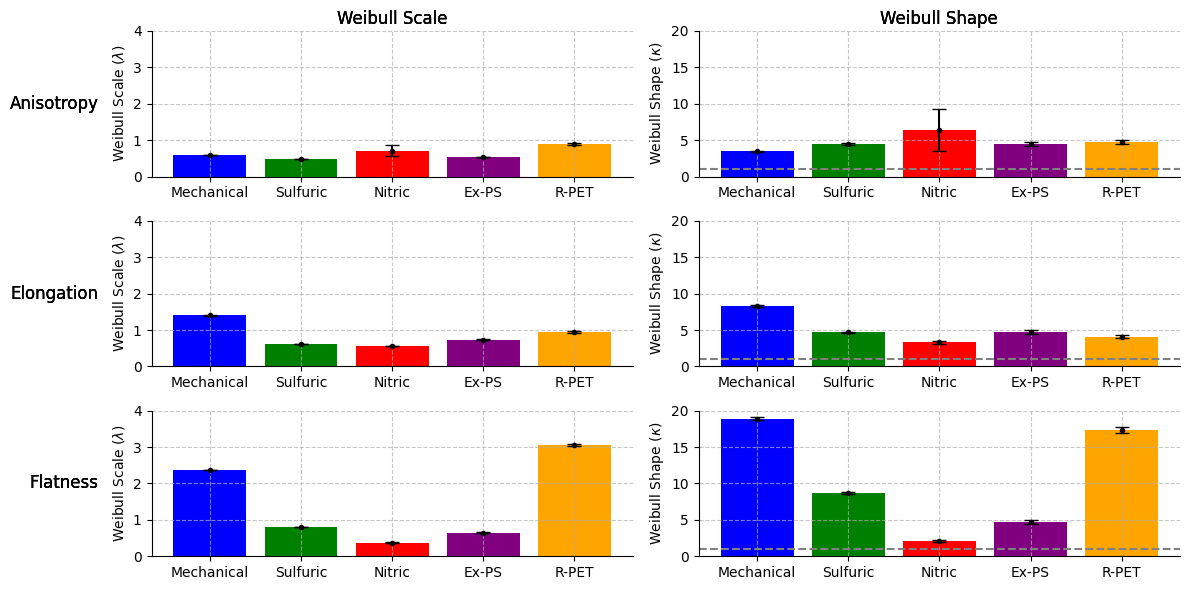

In [37]:
rows = ['Anisotropy', 'Elongation', 'Flatness']
cols = ['Weibull Scale', 'Weibull Shape']

# Create a figure with two horizontally arranged subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 6))  # 3 rows, 2 columns
for j in range(3):
    if j == 0:
        # Subplot 1: Bar plot 1
        axs[j][0].bar(titles, anis_scale, color=colors)
        axs[j][0].errorbar(titles, anis_scale, yerr=errors_anisscale, fmt='.', color='black', capsize=5, label='Confidence Interval')
        # Subplot 2: Bar plot 2
        axs[j][1].bar(titles, anis_shape, color=colors)
        axs[j][1].errorbar(titles, anis_shape, yerr=errors_anisshape, fmt='.', color='black', capsize=5, label='Confidence Interval')
    elif j == 1:
        # Subplot 1: Bar plot 1
        axs[j][0].bar(titles, elong_scale, color=colors)
        axs[j][0].errorbar(titles, elong_scale, yerr=errors_elongscale, fmt='.', color='black', capsize=5, label='Confidence Interval')
        # Subplot 2: Bar plot 2
        axs[j][1].bar(titles, elong_shape, color=colors)
        axs[j][1].errorbar(titles, elong_shape, yerr=errors_elongshape, fmt='.', color='black', capsize=5, label='Confidence Interval')
    elif j == 2:
        # Subplot 1: Bar plot 1
        axs[j][0].bar(titles, flatn_scale, color=colors)
        axs[j][0].errorbar(titles, flatn_scale, yerr=errors_flatnscale, fmt='.', color='black', capsize=5, label='Confidence Interval')

        # Subplot 2: Bar plot 2
        axs[j][1].bar(titles, flatn_shape, color=colors)
        axs[j][1].errorbar(titles, flatn_shape, yerr=errors_flatnshape, fmt='.', color='black', capsize=5, label='Confidence Interval')
    axs[j][1].axhline(y = 1.0, color = 'gray', linestyle = '--') 
    # Set limits - all graph
    axs[j][1].set_ylim(0.0, 20.0)
    axs[j][0].set_ylim(0.0, 4.0)
    # Set ylabels
    for ax, row in zip(axs[:,0], rows):
        ax.set_ylabel('Weibull Scale ($\lambda$)', rotation=90)
    for ax, row in zip(axs[:,1], rows):
        ax.set_ylabel('Weibull Shape ($\kappa$)', rotation=90)
    # Set horizontal titles   
    for ax, col in zip(axs[0], cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad), xycoords='axes fraction', textcoords='offset points', size='large', ha='center', va='baseline')
    # Set vertical titles
    for ax, row in zip(axs[:,0], rows):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0), xycoords=ax.yaxis.label, textcoords='offset points', size='large', ha='right', va='center')
    for i in range(2):
        # Add horizontal lines
        axs[j][i].grid(linestyle='--', alpha=0.7) # axis='y',
        # Remove the upper and right spines
        axs[j][i].spines['top'].set_visible(False)
        axs[j][i].spines['right'].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()
# Display the plot
plt.show()

fig.savefig('tannin-foams-anisotropies-bars.tif')

In [38]:
print('Anisotropy scale: ' + str(anis_params))
print('Elongation: ' + str(elong_params))
print('Flatness: ' + str(flatn_params))

Anisotropy scale: [[0.5845724178177251, 3.4967060764062174], [0.4883761279820742, 4.5066063097633595], [0.71000687526181, 6.379540449485198], [0.5328714260305067, 4.436928509405483], [0.8917422074615503, 4.7209285711600355]]
Elongation: [[1.4005307343012467, 8.32043463918717], [0.6198021505639293, 4.682269831241825], [0.559831643287328, 3.3109592283089877], [0.729377138880172, 4.787417263339766], [0.936912044655283, 4.100774568042941]]
Flatness: [[2.3683614825124435, 18.86221333712892], [0.7971177063863062, 8.682371761883918], [0.3761981000575898, 2.0632706526701634], [0.6420124182594776, 4.702605338998367], [3.0535581176657676, 17.361291984097058]]


## Averages from tables

In [156]:
print('Mechanical volume: ' + str(mechanical['Volume3d'].mean()/1e9) + '+/-' + str(mechanical['Volume3d'].std()/1e9) + ' mm3')
print('Mechanical surface area: ' + str(mechanical['VoxelFaceArea'].mean()/1e6) + '+/-' + str(mechanical['VoxelFaceArea'].std()/1e6)+ ' mm2')
print('Mechanical eq diameter: ' + str(mechanical['EqDiameter'].mean()) + '+/-' + str(mechanical['EqDiameter'].std())+ ' um')
print('Mechanical anisotropy: ' + str(mechanical['Anisotropy'].mean()) + '+/-' + str(mechanical['Anisotropy'].std()))
print('Mechanical elongation: ' + str(mechanical['Elongation'].mean()) + '+/-' + str(mechanical['Elongation'].std()))
print('Mechanical flatness: ' + str( mechanical['Flatness'].mean()) + '+/-' + str( mechanical['Flatness'].std()))

Mechanical volume: 0.004264584244716351+/-0.014008006476716132 mm3
Mechanical surface area: 0.15625877641824248+/-0.2738118241889454 mm2
Mechanical eq diameter: 134.47928621421318+/-97.95737773095658 um
Mechanical anisotropy: 0.572279958676307+/-0.1640652385174657
Mechanical elongation: 0.6025105795050056+/-0.19053167467833332
Mechanical flatness: 0.7052237043103449+/-0.1510186342906922


In [147]:
print('Sulfuric volume: ' + str(sulfuric['Volume3d'].mean()/1e9) + ' +/-' + str(sulfuric['Volume3d'].std()/1e9) + ' mm3')
print('Sulfuric surface area: ' + str(sulfuric['VoxelFaceArea'].mean()/1e6) + ' +/-' + str(sulfuric['VoxelFaceArea'].std()/1e6)+ ' mm2')
print('Sulfuric eq diameter: ' + str(sulfuric['EqDiameter'].mean()) + ' +/-' + str(sulfuric['EqDiameter'].std())+ ' mm')
print('Sulfuric anisotropy: ' + str(sulfuric['Anisotropy'].mean()) + ' +/-' + str(sulfuric['Anisotropy'].std()))
print('Sulfuric elongation: ' + str(sulfuric['Elongation'].mean()) + ' +/-' + str(sulfuric['Elongation'].std()))
print('Sulfuric flatness: ' + str(sulfuric['Flatness'].mean()) + ' +/-' + str(sulfuric['Flatness'].std()))

Sulfuric volume: 0.003317807619126819 +/-0.005228987652793317 mm3
Sulfuric surface area: 0.1565007767151767 +/-0.14227803422541108 mm2
Sulfuric eq diameter: 158.29057665047222 +/-66.53916975726409 mm
Sulfuric anisotropy: 0.49298145434511437 +/-0.1109046128600931
Sulfuric elongation: 0.6480461716839917 +/-0.1347319802698384
Sulfuric flatness: 0.7878588428274429 +/-0.1033768075232463


In [148]:
print('Nitric volume: ' + str(nitric['Volume3d'].mean()/1e9) + ' +/-' + str(nitric['Volume3d'].std()/1e9) + ' mm3')
print('Nitric surface area: ' + str(nitric['VoxelFaceArea'].mean()/1e6) + ' +/-' + str(nitric['VoxelFaceArea'].std()/1e6)+ ' mm2')
print('Nitric eq diameter: ' + str(nitric['EqDiameter'].mean()) + ' +/-' + str(nitric['EqDiameter'].std())+ ' um')
print('Nitric anisotropy: ' + str(nitric['Anisotropy'].mean()) + ' +/-' + str(nitric['Anisotropy'].std()))
print('Nitric elongation: ' + str(nitric['Elongation'].mean()) + ' +/-' + str(nitric['Elongation'].std()))
print('Nitric flatness: ' + str(nitric['Flatness'].mean()) + ' +/- ' + str(nitric['Flatness'].std()))

Nitric volume: 0.017015906287220026 +/-0.028564411916448405 mm3
Nitric surface area: 0.47151697496706196 +/-0.48141829795506375 mm2
Nitric eq diameter: 259.74795148608695 +/-133.08071190417598 mm
Nitric anisotropy: 0.6583641488801054 +/-0.138785379819238
Nitric elongation: 0.6047121870882741 +/-0.1686836257947496
Nitric flatness: 0.5725380105401845 +/- 0.17006552883609508


In [157]:
print('Ex-PS volume: ' + str(xps['Volume3d'].mean()/1e9) + ' +/-' + str(xps['Volume3d'].std()/1e9) + ' mm3')
print('Ex-PS surface area: ' + str(xps['VoxelFaceArea'].mean()/1e6) + ' +/-' + str(xps['VoxelFaceArea'].std()/1e6) + ' mm2')
print('Ex-PS eq diameter: ' + str(xps['EqDiameter'].mean()) + ' +/-' + str(xps['EqDiameter'].std()) + ' um')
print('Ex-PS anisotropy: ' + str(xps['Anisotropy'].mean()) + ' +/-' + str(xps['Anisotropy'].std()))
print('Ex-PS elongation: ' + str(xps['Elongation'].mean()) + ' +/-' + str(xps['Elongation'].std()))
print('Ex-PS flatness: ' + str(xps['Flatness'].mean()) + ' +/-' + str(xps['Flatness'].std()))

Ex-PS volume: 0.023657559835051547 +/-0.012172850710318373 mm3
Ex-PS surface area: 0.6781182680412371 +/-0.23045957010124268 mm2
Ex-PS eq diameter: 345.0850373797071 +/-63.36523862449951 um
Ex-PS anisotropy: 0.5670885228276878 +/-0.12469591858191394
Ex-PS elongation: 0.6492102754050074 +/-0.16102539857227227
Ex-PS flatness: 0.6766129823269513 +/-0.14322993310857135


In [149]:
print('R-PET volume: ' + str(pet['Volume3d'].mean()/1e9) + '+/-' + str(pet['Volume3d'].std()/1e9) + ' mm3')
print('R-PET surface area: ' + str(pet['VoxelFaceArea'].mean()/1e6) + '+/-' + str(pet['VoxelFaceArea'].std()/1e6) + ' mm2')
print('R-PET eq diameter: ' + str(pet['EqDiameter'].mean()) + '+/-' + str(pet['EqDiameter'].std())+ ' um')
print('R-PET anisotropy: ' + str(pet['Anisotropy'].mean()) + '+/-' + str(pet['Anisotropy'].std()))
print('R-PET elongation: ' + str(pet['Elongation'].mean()) + '+/-' + str(pet['Elongation'].std()))
print('R-PET flatness: ' + str(pet['Flatness'].mean()) + '+/-' + str(pet['Flatness'].std()))

R-PET volume: 0.03744150234808259+/-0.04978506702072565 mm3
R-PET surface area: 0.676726796460177+/-0.7619986689443191 mm2
R-PET eq diameter: 268.62353912074803+/-246.4368737012908 mm
R-PET anisotropy: 0.677774563421829+/-0.20238561413462436
R-PET elongation: 0.5130769702064897+/-0.24116387846540097
R-PET flatness: 0.6001198303834808+/-0.2107783708944764
